In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import tensorflow as tf
import pandas as ppipd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [11]:
train_imgs_path = r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\train\Images\images"
train_masks_path = r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\train\Masks\masks"
test_imgs_path =r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test\Images\images"
test_masks_path =r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test\Masks\masks"

(512, 512, 3) 0 255


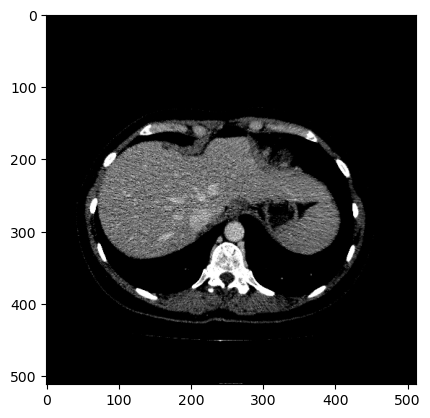

In [12]:
img = cv2.imread(r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\train\Images\images\image_100.png")
plt.imshow(img)
print(img.shape, np.amin(img), np.amax(img))

(512, 512, 3) 0 255


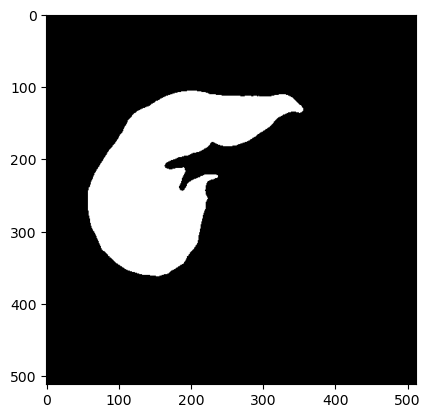

In [13]:
img = cv2.imread(r"C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test\Masks\masks\mask_100.png")
plt.imshow(img)
print(img.shape, np.amin(img), np.amax(img))

In [14]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)
def trainGenerator(batch_size,train_path,image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (256,256),
                   seed = 1,
                   subset = 'training'):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset = subset)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset = subset)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [16]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)
train_generator = trainGenerator(16,r'C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,r'C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))

In [17]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [18]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

Found 1647 images belonging to 1 classes.
Found 1647 images belonging to 1 classes.


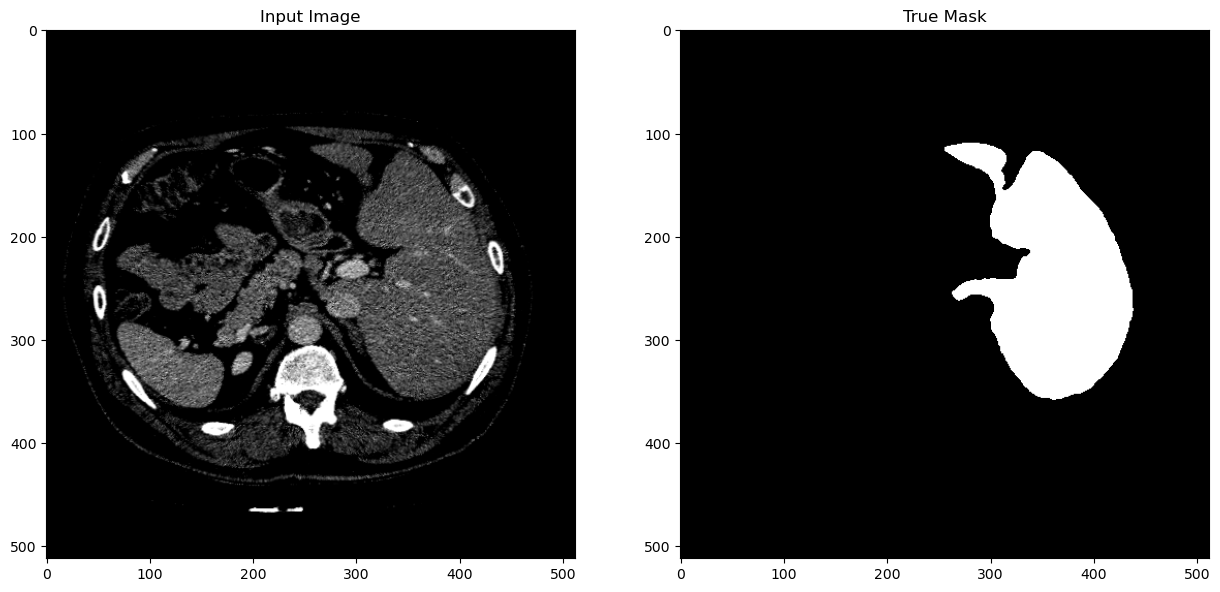

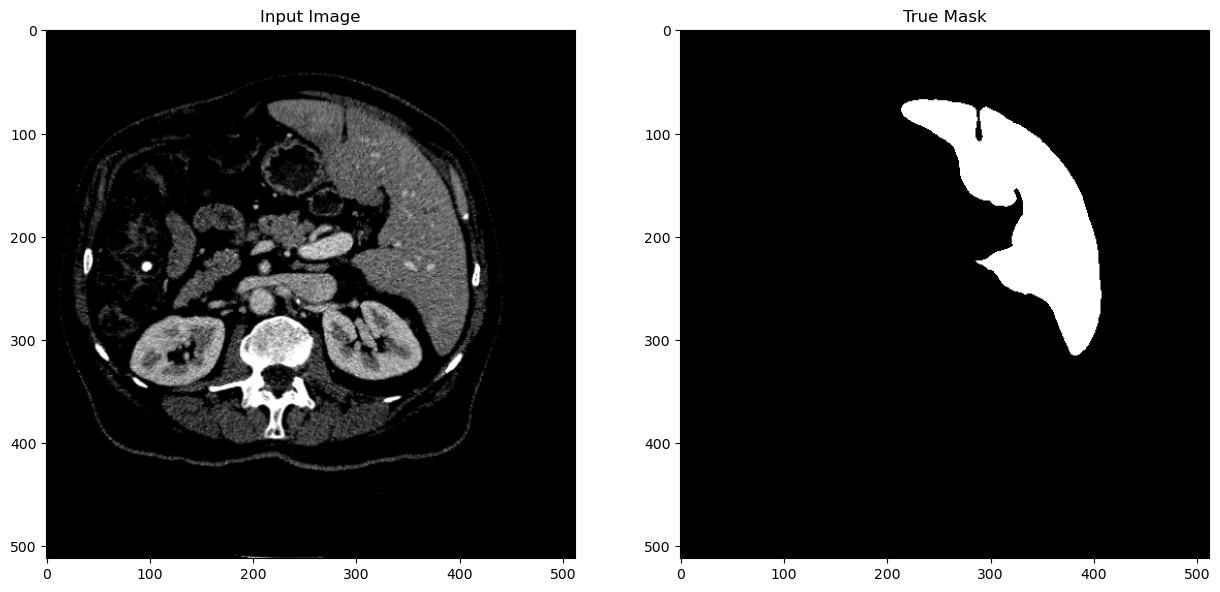

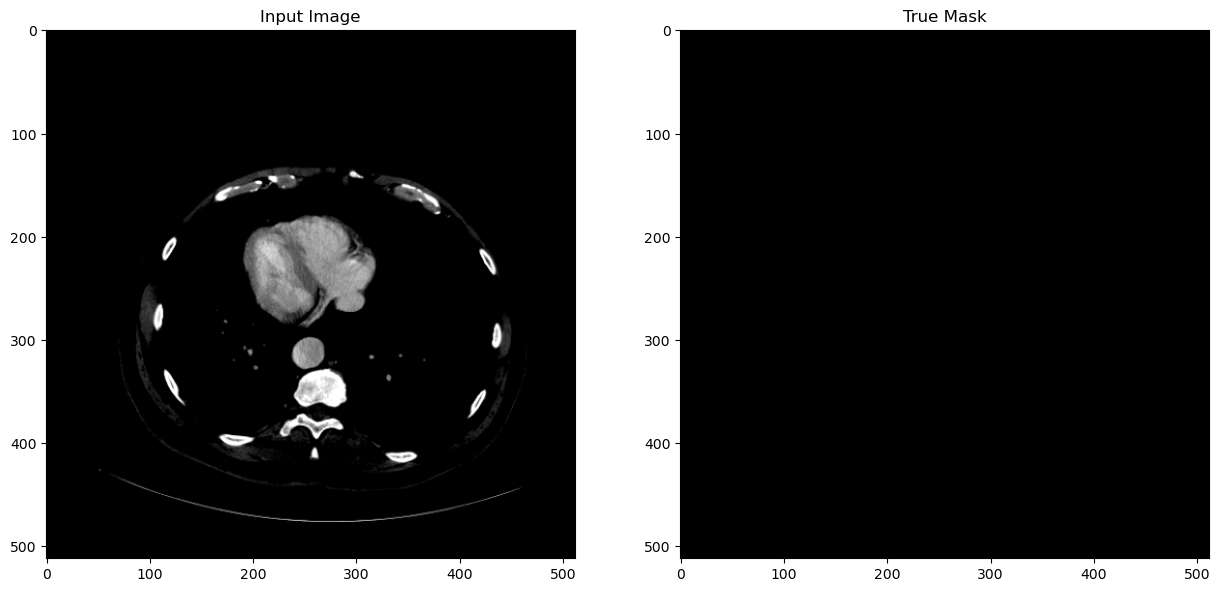

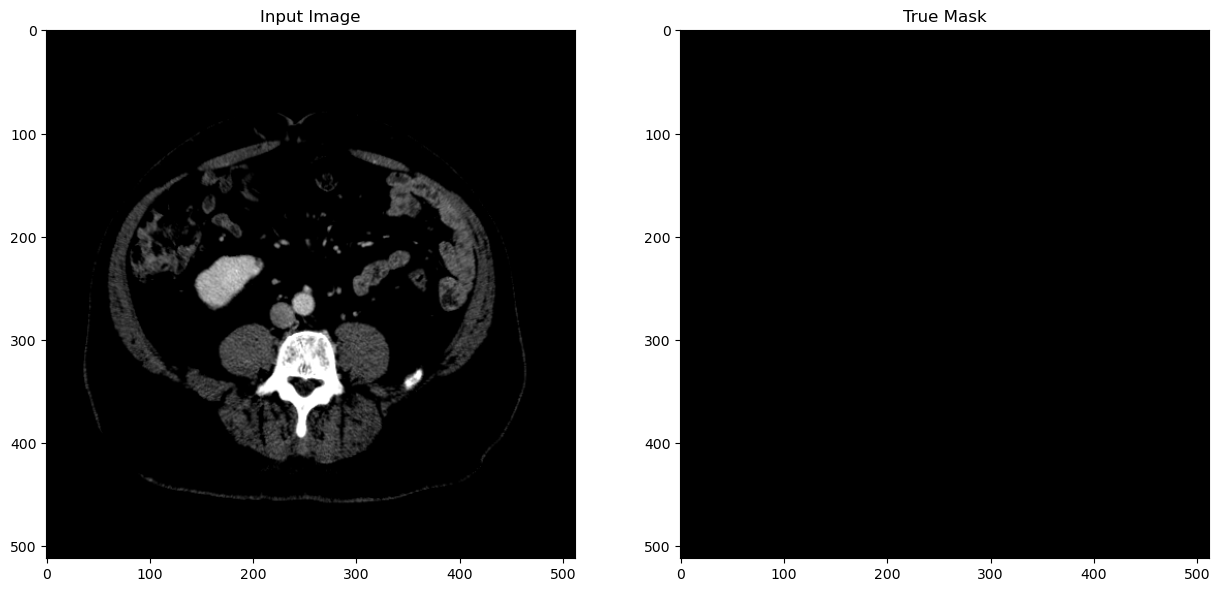

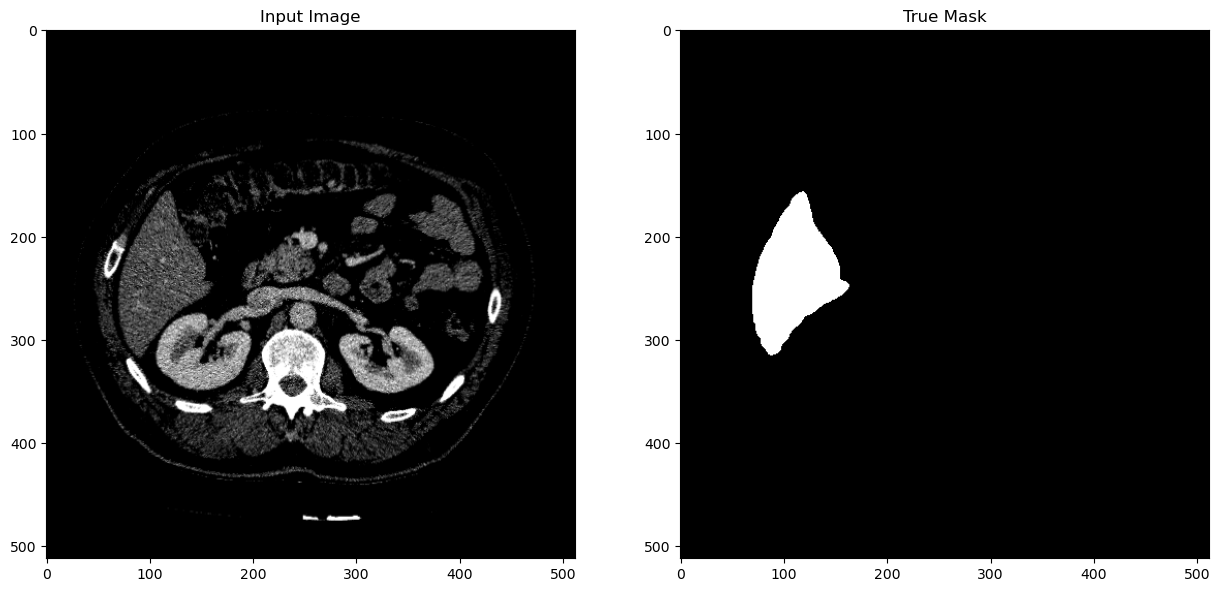

In [19]:
show_dataset(train_generator, 5)

Found 411 images belonging to 1 classes.
Found 411 images belonging to 1 classes.


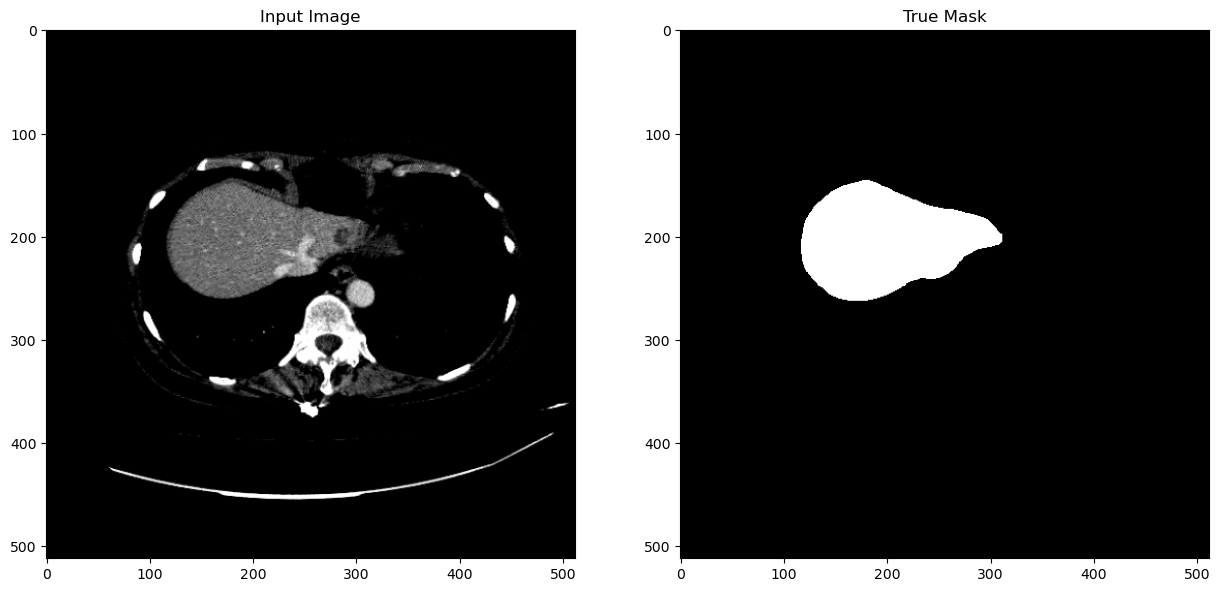

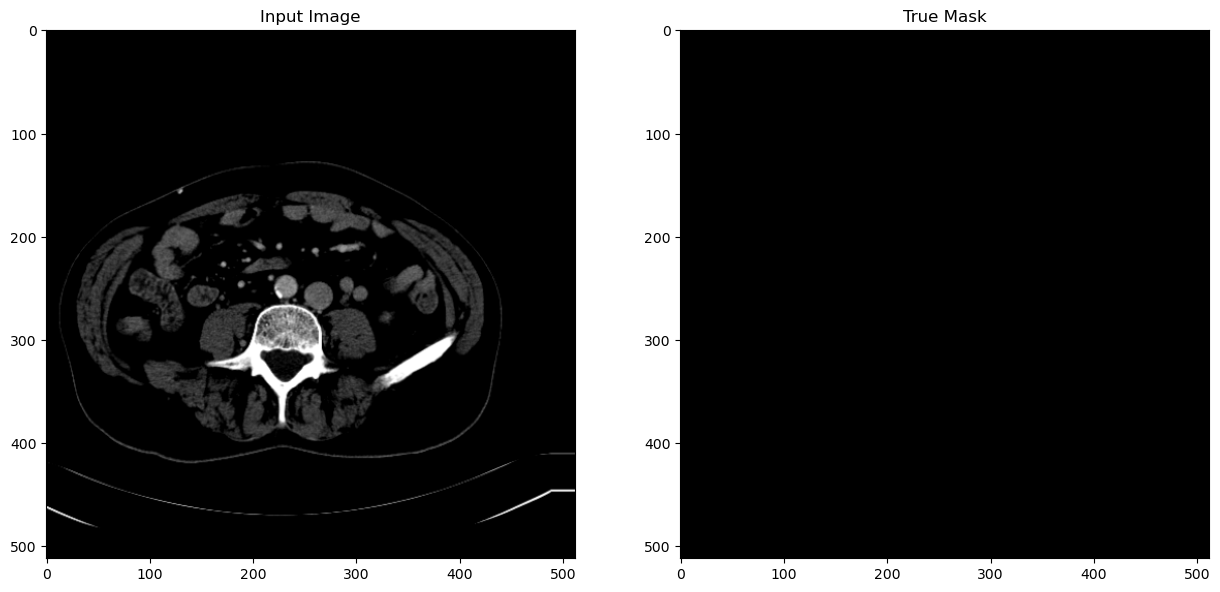

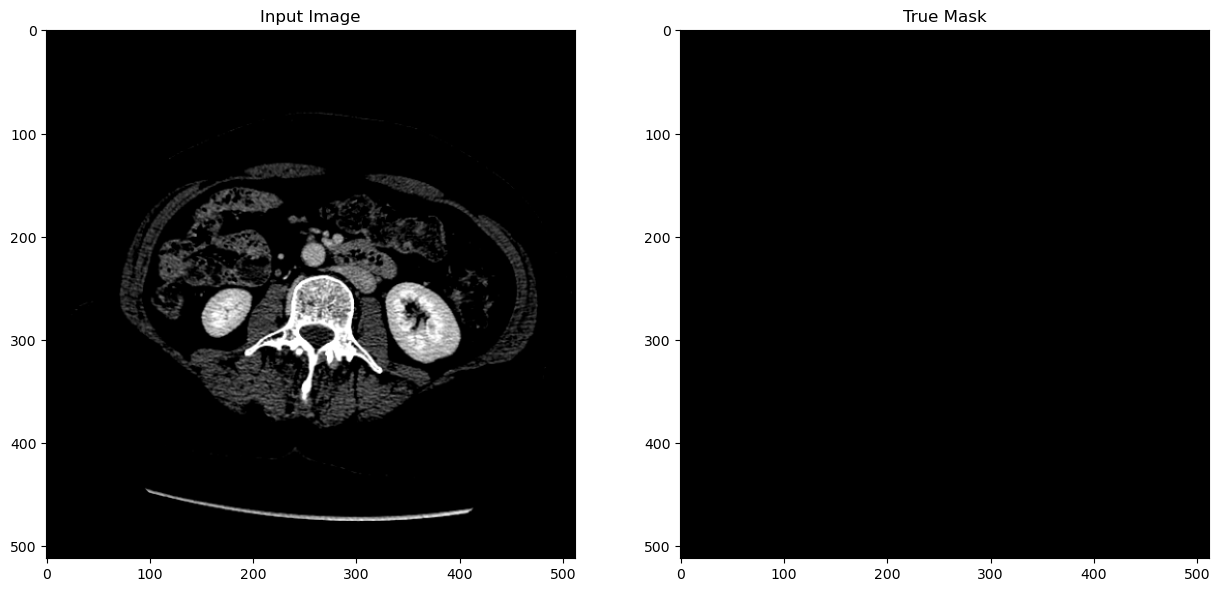

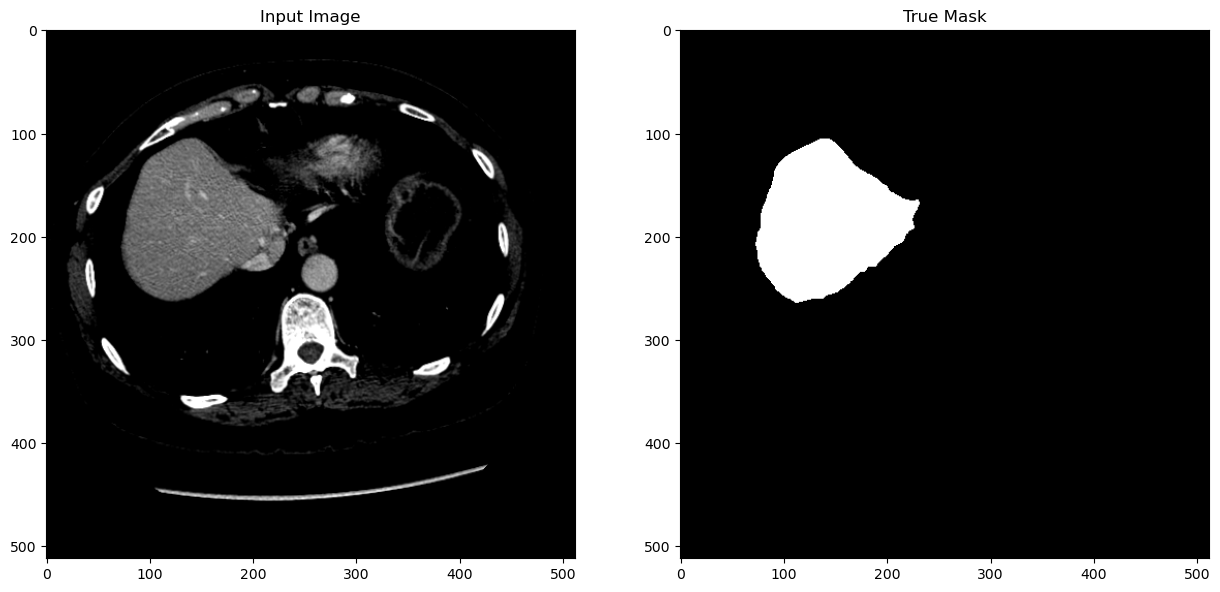

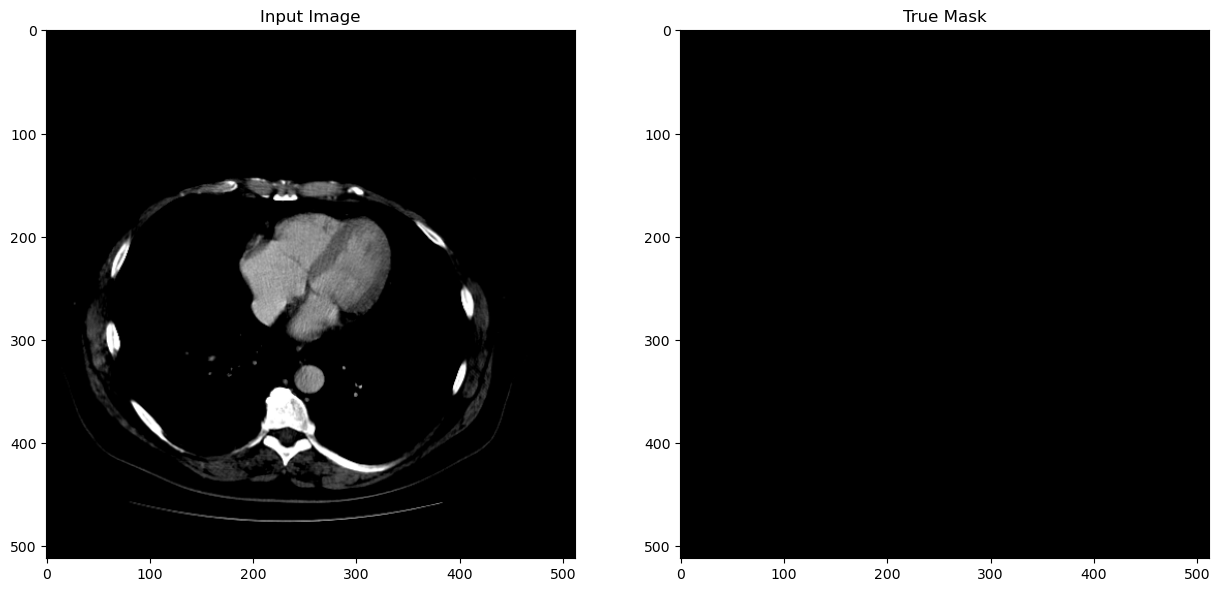

In [15]:
show_dataset(valid_generator, 5)

In [20]:
model = unet(input_size=(512,512,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 512, 512, 1)  33          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 7,759,521
Trainable params: 7,759,521
Non-trainable params: 0
__________________________________________________________________________________________________


In [21]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [23]:
num_train = 1647
num_valid = 411
train_batchsize = 16
valid_batchsize = 16
Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 100

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=Step_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=Step_valid,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/100


Phân đoạn cho một loạt ảnh sử dụng ImageDataGenerator

In [ ]:
data_gen_args = dict(
                    fill_mode='nearest',
                    validation_split=0)
test_generator = trainGenerator(1,r'C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))

In [ ]:
show_dataset(test_generator, 5)

In [ ]:
results = model.predict_generator(test_generator,765,verbose=1)

In [ ]:
results.shape

(765, 512, 512, 1)

In [ ]:
results[results >= 0.5] = 255
results[results < 0.5] = 0
results = np.asarray(results, np.uint8)

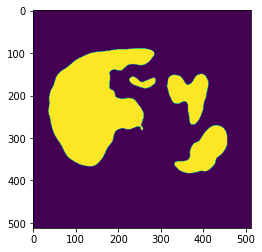

In [ ]:
plt.imshow(results[5])

Phân đoạn cho từng ảnh một

Ảnh dự đoán và true mask: 


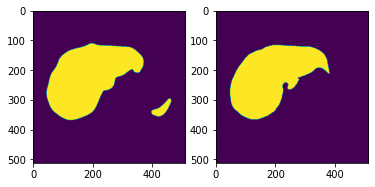

In [ ]:
img = cv2.imread(r'C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test\Images\images\image_5.png')
img = img/255
image = img[:,:,0]
image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
image_tensor = tf.expand_dims(image_tensor, 0)
mask = model.predict(image_tensor)
mask[mask >= 0.5] = 255
mask[mask < 0.5] = 0
mask = np.asarray(mask, np.uint8)
print('Ảnh dự đoán và true mask: ')
plt.subplot(1,2,1)
plt.imshow(mask[0])
plt.subplot(1,2,2)
true_mask = cv2.imread(r'C:\Users\User\OneDrive\Desktop\Final_project\Image Dataset\3DIRCADB\test\Masks\masks\mask_5.png')
_true_mask = true_mask[:,:,0]
plt.imshow(_true_mask)